In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma as gamma_function
import math

In [2]:
class Cuckoo():
    
    X_min = 0
    X_max = 100
    alpha_min = 0.9
    alpha_max = 1.0
    pa_min = 0.05
    pa_max = 0.25
    N_nest = 25
    N_itertotal = 100
    gamma = 0.1          # noise factor
    lamda = 1.5          # constant used in le'vy flight
    
    total_nodes = 0
    anchor_percent = 0
    t_range = 0 # transmission range
    
    X_anchor = []
    X_unknown = []
    
    X_loc = []

    
    def __init__(self, total_nodes=100, anchor_percent = 0.20, t_range = 25):
        self.total_nodes = total_nodes
        self.anchor_percent = anchor_percent
        self.t_range = t_range
        self.M = int(self.anchor_percent * self.total_nodes) # no. of anchor nodes
        self.N = self.total_nodes - self.M # no. of unknown nodes
        
        
        for i in range(self.M):
            x_anchor = np.random.randint(100)
            y_anchor = np.random.randint(100)
            self.X_anchor.append([x_anchor, y_anchor])
        
        for i in range(self.N):
            x_unknown = np.random.randint(100)
            y_unknown = np.random.randint(100)
            self.X_unknown.append([x_unknown, y_unknown])
        
        self.X_unknown = np.array(self.X_unknown)
        self.X_anchor = np.array(self.X_anchor)
    
        self.X_anchor_og = self.X_anchor.copy()
        self.X_unknown_og = self.X_unknown.copy()
    
    def show_field(self):
        plt.figure(figsize=(8, 8))
        plt.plot(self.X_unknown[:, 0], self.X_unknown[:, 1], 'ro', label="Unknown Node")
        plt.plot(self.X_anchor[:, 0], self.X_anchor[:, 1], 'go', label="Anchor Node")
        plt.legend()
        plt.grid()
        plt.show()
        
        
    # step size (alpha)
    def alpha(self, n_iter):
        return self.alpha_max - ((n_iter/ self.N_itertotal) * (self.alpha_max - self.alpha_min)) # returns step size value

    # Le'vy flight function
    def levy(self):
        temp = np.power(((gamma_function(1 + self.lamda) * np.sin(np.pi * (self.lamda /2))) / (gamma_function((1 + self.lamda)/2) * self.lamda * np.power(2, ((self.lamda - 1)/2)) )), 1/self.lamda)
        u = np.random.normal(0, temp)
        v = np.random.normal(0,1)
        r = u / (np.power(abs(v), (1/self.lamda)))

        return r  # random walk value

    
    # location limit tester
    def limiter(self, point):
        x = point[0]
        y = point[1]
        if x > self.X_max and y > self.X_max:
            x,y = self.X_max, self.X_max
            # X_j = X_rand
        elif x > self.X_max and self.X_min < y < self.X_max:
            x,y = self.X_max, y
            # X_j = X_rand
        elif x > self.X_max and y < self.X_min:
            x,y = self.X_max, self.X_min
            # X_j = X_rand
        elif self.X_min < x < self.X_max and y < self.X_min:
            x,y = x, self.X_min
            # X_j = X_rand
        elif x < self.X_min and y < self.X_min:
            x,y = self.X_min, self.X_min
            # X_j = X_rand
        elif x < self.X_min and self.X_min < y < self.X_max:
            x,y = self.X_min, y
            # X_j = X_rand
        elif x < self.X_min and y > self.X_max:
            x,y = self.X_min, self.X_max
            # X_j = X_rand
        elif self.X_min < x < self.X_max and y > self.X_max:
            x,y = x, self.X_max
            # X_j = X_rand

        return [x,y]

    
    def neighbours(self, node, anchors):
        x = node[0]
        y = node[1]
        X_anchor = anchors
                
        l = []
        for j in range(len(X_anchor)): # for every anchor nodes
            dist_real = np.power((np.power((x - X_anchor[j][0]), 2) + np.power((y - X_anchor[j][1]), 2)), 0.5)
            dist_err = dist_real + np.random.normal(0, (self.gamma*dist_real))

            if dist_err < self.t_range:
                l.append(X_anchor[j])
                
        return l # neighbouring anchors coordinates

    def objective(self, node, n_anchors):
        """objective function (to minimize)"""
        x = node[0]
        y = node[1]
        
        l = self.neighbours(node, n_anchors)
        m = len(l)
        rerror = []
        if len(l) >= 3:
            for ancn in l:
                dist_real = np.power((np.power((x - ancn[0]), 2) + np.power((y - ancn[1]), 2)), 0.5)
                dist_err = dist_real + np.random.normal(0, (self.gamma*dist_real))
                rerror.append(np.power(dist_real - dist_err,2))

        ans = None
        if math.isnan(np.sum(rerror)/m): 
            ans = np.inf
        else:
            ans = np.sum(rerror)/m or None
            
        return ans # mean of square of ranging error

    
    def mod_cs(self, N_anchor):
        X_nest = []
        for i in range(self.N_nest):
            x_nest = np.random.randint(100)
            y_nest = np.random.randint(100)
            X_nest.append([x_nest, y_nest])
        
        Obj_X_nest = []
        for i in range(len(X_nest)):
            Obj_X_nest.append(self.objective(X_nest[i], N_anchor))
        
#         print(Obj_X_nest)
        
        N_iter = 0
        fmins = []
        while(N_iter < self.N_itertotal):
            N_iter += 1
            X_js = []
            for i in range(len(X_nest)):
                X_j = X_nest[i].copy()
                X_j[0] = X_j[0] + self.alpha(N_iter) * self.levy()
                X_j[1] = X_j[1] + self.alpha(N_iter) * self.levy()
                
                X_j = self.limiter(X_j)
                
                F_j = self.objective(X_j, N_anchor) or np.inf
                
                rand_k = np.random.randint(0, len(X_nest))
                
                F_k = self.objective(X_nest[rand_k], N_anchor) or np.inf
                
                if F_j > F_k:
                    X_j[0] = X_nest[rand_k][0]
                    X_j[1] = X_nest[rand_k][1]
                    F_j = F_k

                X_js.append(X_j)
                
            Obj_X_js = []
            for i in range(len(X_js)):
                Obj_X_js.append(self.objective(X_js[i], N_anchor))
            
            Obj_X_js = np.array([np.inf if i is None else i for i in Obj_X_js])
            F_min = Obj_X_js[np.argmin(Obj_X_js)]
#             print(F_min)
            best_sol = X_js[np.argmin(Obj_X_js)]
            
            Pa_j = []
            
            for i in Obj_X_js:
                K = i - F_min
                if K < 1:
                    Pa_j.append(self.pa_min + (self.pa_max - self.pa_min) * K)
                else:
                    Pa_j.append(self.pa_max / N_iter)

            
            for i in range(len(Pa_j)):
                rand_temp = np.random.uniform(0, 1)
                if rand_temp < Pa_j[i]:
                    my_x = np.random.randint(100)
                    my_y = np.random.randint(100)
                    if (self.objective(X_js[i], N_anchor) or np.inf) > (self.objective([my_x, my_y], N_anchor) or np.inf):
                        X_js[i] = [my_x, my_y]
            
            
            Obj_X_js = []
            for i in range(len(X_js)):
                Obj_X_js.append(self.objective(X_js[i], N_anchor))
            
            Obj_X_js = np.array([np.inf if i is None else i for i in Obj_X_js])
            F_min = Obj_X_js[np.argmin(Obj_X_js)]
            print(F_min)
            fmins.append(F_min)
            best_sol = X_js[np.argmin(Obj_X_js)]
            X_nest = X_js.copy()
        
        return best_sol
        
        plt.plot(fmins)
        plt.show()

                
                
    
    def update_Unknown(self, indexes):        
        """Updating Unknown List"""
        
        X_unknown_temp = []
        for j in range(len(self.X_unknown)):
            if j in indexes:
                pass
            else:
                X_unknown_temp.append(self.X_unknown[j])

        self.X_unknown = np.array(X_unknown_temp)
        
    
    
    
    def main(self):
        
        localised_indexes = []
        for i in range(len(self.X_unknown)):
            nn = self.neighbours(self.X_unknown[i], self.X_anchor)
            print(i, end="\r")
            if len(nn) >= 3:
                updated_node_location = self.mod_cs(nn)
                
                self.X_loc.append([updated_node_location, self.X_unknown[i]])
                
                # Updated 
                X_anchor_temp = list(self.X_anchor)
                X_anchor_temp.append(updated_node_location)
                self.X_anchor = np.array(X_anchor_temp)
                
                localised_indexes.append(i)
        
        self.update_Unknown(localised_indexes)
                

                
            
            
        

In [3]:
coco = Cuckoo(anchor_percent=0.1, t_range=25)

In [4]:
coco.main()

5.884237964060507
1.4627420732583911
0.5101495339203902
0.1997976733855256
0.5291466508785233
0.7039996443616391
0.35949702230011366

c:\users\kotiyal\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in double_scalars



0.1020683960620748
0.2823765313664038
0.34329928900604006
0.1013339993910482
0.03835838592061636
0.3556329712173653
0.1867995342970521
0.5049220491291697
0.11359325716393731
0.04475054310717835
0.5149282079613096
0.6799441905005826
0.3132496650526135
0.4094447518343054
0.19092268225218975
0.09098942643265841
0.39381210853893656
0.354203126852158
0.10674674926426798
0.25494486948085654
0.5699802404847502
0.28146225213067455
0.14084654783112374
0.11624158574661193
0.026609737217238544
0.0887476716943657
0.23820860656988233
0.4292634148838719
0.4857654539497121
0.2305175100783766
0.04155735968729168
0.06845263494777871
0.07945825482764553
0.1894455378420693
0.16397776375637793
0.5374684249463734
0.6049232074292291
0.13777574146557992
0.42051315149667984
0.27796456818943416
0.16208319038433353
0.04971173271429277
0.20523276549433148
0.03714643687118654
0.47590682499295794
0.4143401157403847
0.09498208031602107
0.47049156518104995
0.028317019678558097
0.5741218041436408
0.29064845992062804

0.1471035529859222
0.01671283927295312
0.2801668970198592
0.05540049215708831
0.054925223719183826
0.005263301897508725
0.1754874302192861
0.1274874467600417
0.0012889299707255389
0.0802315696062225
0.12108985652080172
0.08600194042207153
0.19471912320376938
0.06777709944687972
0.1121294567840662
0.0660222923471802
0.23923148636136266
0.06146638339567182
0.029174982850393907
0.21942011507727305
0.13619212050143087
0.19308407148516862
0.16803440443811293
0.06510749948309313
0.22774587409938415
0.09730132007105527
0.0961223836460749
0.08050116955426417
0.26010381130972493
0.15431896100905154
0.08856866295247152
0.03898921509609299
0.14010105899487826
0.12931599635747318
0.04899996899393151
0.03892175806939206
0.14507231697237297
0.22097046186193162
0.13461010845100765
0.05160242868401236
0.04198344150261971
0.13176185429353385
0.12618315746550823
0.08369040682040099
0.051951673007699116
0.014504305471756108
0.24060697619016358
0.014676012287872136
0.14192339627550307
0.025198545348257727

0.03544584438301401
0.01422824652789028
0.007380634942854958
0.01023623843059325
0.03893559986357989
0.05288269910488461
0.02446871883682228
0.024778545308599843
0.03140602276387356
0.00047558885694779104
0.01828259359299341
0.007983687218637486
0.027149651947120487
0.05498680020754109
0.05824944011190126
0.024687529468734037
0.024111170233775406
0.04796422007025946
0.0369869209395022
0.11472921988151301
0.01903607830169309
0.01834999271933284
0.012657669603863386
0.040244072331138324
0.006112158863697879
0.02522503969967946
0.015005791510600294
0.0349224580004195
0.06396812504672568
0.031479261781710004
0.020685656727818393
0.08175424630802339
0.00788638963891841
0.033616966044306675
0.020137220863828558
0.07643249095387364
0.010719597390042052
0.022320225937019517
0.006197072884138465
0.021841782158789323
0.00409566973363424
0.01981662979331619
0.014738587133031252
0.04945341801986164
0.026578154024602358
0.07213505218979134
0.038836224738069025
0.06887874604655088
0.0444673562420148

0.28000748112463925
0.2693310174353561
0.2982900467260509
0.3460817264363568
0.20183081896602623
0.2730022041955046
0.4016924494472453
0.21250153123519472
0.2681953061382983
0.23154735174237467
0.3222557732665881
0.23500525488925897
0.24335378986690748
0.17611416247289907
0.2711524045900064
0.33187899111898006
0.2942347049584707
0.32907231747370186
0.33351984589935285
0.1884793700134851
0.15937574356702758
0.34962284688001355
0.22255283561651085
0.3199570974190556
0.17073791336937086
0.17557287169461416
0.06396205104686668
0.537829771132719
0.13993275644457864
0.24666438549045172
0.25639600435068366
0.3707032635003423
0.4311354903203691
0.22080396818405565
0.29954974007694685
0.2581485964579445
0.39013285624895444
0.5871723835703185
1.026958357722912
1.0301012046504063
0.5115908061873052
0.7456189028562887
0.8182233923921917
0.495029695691687
0.5275159435286468
0.6470927732906611
0.6191609859182619
0.618176591420119
0.3652761316387692
0.2257078765770084
0.48963122051569413
0.6787511642

c:\users\kotiyal\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:192: RuntimeWarning: invalid value encountered in double_scalars


0.6228144189933322
0.5161736995014649
0.038089269344200885
0.14051558499445665
0.32759607672902585
0.6105372736569592
0.41002692356274767
0.2756665999627507
0.10068484394804478
0.17666425392068305
0.4117982982771389
0.09164535138026768
0.05922420045642551
0.2611078256320618
0.10862371547151006
0.1660795570341526
0.05226499089366169
0.11717177975155925
0.21353730214738584
0.381078326051606
0.1458187154944819
0.07953522499435763
0.03901686181568715
0.008844380978279984
0.02167411160972853
0.0687596841360807
0.03693640692234782
0.04479145630860789
0.008698734941636517
0.02685717018984414
0.0487062199750069
0.1064330589968201
0.08781529348684491
0.2526359352801249
0.03824917589951501
0.19736168917350852
0.037251076203439946
0.25973926723227836
0.025002724545975814
0.08865741122054822
0.07308430868893286
0.04716425655620735
0.057039159958750814
0.035048629336516195
0.13817710361734678
0.051416918323150616
0.18637255215155657
0.17506529705169893
0.11546129036474406
0.10323556419224235
0.2372

0.025957848606728368
0.08620172881561819
0.005728978664042756
0.06623888741046416
0.12067923308538726
0.129924496240596
0.11382196674001807
0.05841260454678532
0.06849082776482124
0.020943530534928687
0.09873969227645804
0.07445612187797282
0.05371479712574475
0.0805250104416458
0.06607302788829471
0.07614052347036934
0.007914381168028572
0.05618279622271442
0.047992632629426754
0.0828014768781185
0.14720114240898868
0.0532845036790871
0.04693896243222091
0.08356225205854244
0.07898437309567548
0.08282562348744198
0.11039192770971684
0.06581110464407139
0.15152539628852232
0.08140342797358584
0.006108633428842105
0.05850494402052144
0.11780989856599591
0.1451318082963618
0.09509788484321038
0.149383350782553
0.05122480549589834
0.1073022865770549
0.015191738690871676
0.07709686738511207
0.0742003139637811
0.042866599263562774
0.0336051363226803
0.03540213795246682
0.05005454967135732
0.1754596920475638
0.014450307803117447
0.05950745664231936
0.06858394727895659
0.03547881471770188
0.1

0.10923225225442035
0.06966858988307452
0.02124285281664898
0.06491073436921659
0.1133994877516598
0.18263887318077296
0.042122716867378486
0.10259612516375707
0.10791580964762648
0.13753553266422675
0.062449173343623036
0.027469569180571553
0.07150762962513602
0.08152392068987138
0.027454097097027175
0.07307812724030537
0.15693877748929144
0.1163993351044018
0.07912230504988385
0.07702261483773747
0.09199181144282911
0.06035792323683321
0.033429931299513216
0.06538548472230145
0.04411938809263168
0.02297495076374443
0.1357241439262397
0.07035659500506694
0.004266495844565965
0.06473577211616735
0.09975131611361285
0.0262680618112269
0.09482574361689608
0.04706349048524267
0.019684501049848886
0.053637476661671624
0.1056853675691178
0.13450221233775436
0.028035870290684335
0.05864810918737379
0.15813013936195916
0.03776788406528753
0.04404024073040634
0.14017127922265954
0.11780151069846341
0.04141699372240303
0.1200613807818756
0.07068251173526449
0.05935794725549084
0.029468237642043

0.17198459497705645
0.17333677017202323
0.2447293680798174
0.2761229472759976
0.22822947826383214
0.08111423765504508
0.1796023566215694
0.17689623733592036
0.1837905605942025
0.2472231721867702
0.25384668423849055
0.0924470269549672
0.30367011334898436
0.24801849624909045
0.1673849552394578
0.24405322051815992
0.1805583521603175
0.17498006928797558
0.23532267724409137
0.1681012910318391
0.18813823313543926
0.2362678656128769
0.1991943267330142
0.2000705641632813
0.16992306325392273
0.24020981434388802
0.20338527087052108
0.14298503377767466
0.2134317549508631
0.19727992926540755
0.22489976794434124
0.1426458497431777
0.05720061198778917
0.1601905804780883
0.11993555200352736
0.11309232594552238
0.11207202574036887
0.14355557132865857
0.20035030275901078
0.19973941786412822
0.16695361493655983
0.15239152985507087
0.14468400918550378
1.038336144045496
0.8005028034822981
1.0703716190561225
0.6863850779625833
0.904715959604115
0.5720139923175255
0.6848120575457337
0.5912980786258432
0.634

0.05483132253930669
0.045791441797316305
0.035107512176050175
0.04355009994312
0.028732173634549066
0.06516418274056557
0.05613991541552701
0.12165767179485922
0.009608178000654664
0.036717809639197165
0.08229940811545526
0.04795125242628256
0.032022219405707215
0.02815625574342985
0.06285304225022002
0.01838425072268885
0.020649682557674836
0.03224353175018722
0.15413186972213214
0.04738642791542655
0.04590702460566918
0.0390380067767335
0.08796783586524815
0.08293196219263368
0.07192339239881289
0.05941304707553536
0.06878636898519486
0.08682127177930798
0.03743076736064733
0.06328024052138191
0.15542019075819227
0.3795405070065834
0.3251446754020491
0.19359766065504666
0.10745390601341985
0.18000410171395081
0.03532713466473045
0.07946054281809424
0.053867207879893686
0.11345374705120922
0.1620855903154284
0.05273780028034346
0.052791114251888725
0.0644561663578018
0.07799952874277893
0.08120986419158611
0.047940239670603284
0.11095048645474635
0.06113085982565976
0.1251792818863845

0.19175128530903487
0.07850250733324753
0.02329875554891311
0.007585967858690424
0.011701725720485202
0.009407635467554416
0.010173206828903028
0.020040813380695372
0.1426619143774174
0.015455371690127138
0.007378997434952007
0.007967597353021239
0.08898429286005478
0.03162040157665167
0.15831785550448885
0.04045522692795729
0.14975796625838572
0.041318705147014814
0.015978085486403074
0.14149570657676042
0.052863359750097004
0.19890682777492388
0.1128404412199682
0.06408967531842873
0.11184300400226792
0.08271580608053407
0.09541077553770179
0.03910527808672708
0.05994765843834695
0.0029434756467774264
0.02311769172738924
0.02409979911551461
0.013864434748489024
0.032442523569388454
0.010732462483567278
0.01455628645631031
0.008248237778762667
0.023217873010837574
0.029702530958848884
0.011724113617109237
0.012023218634269351
0.025260522134791186
0.025023481092568335
0.0739758074834723
0.013094231752735575
0.01006868522488221
0.008907417595773955
0.002911888274018251
0.016675550076536

0.2811237145746844
0.49075881995875736
0.3528712579057638
0.42009101743990784
0.3269984179532498
0.44107900184822424
0.3691240887764454
0.45823244844410616
0.4687135920289406
0.4885481779222832
0.5185561981666192
0.45369647817365943
0.45351173135148093
0.4229395128710604
0.6585864603602654
1.3317896772530695
0.37255764014800913
0.41432151903797854
0.5752302788294751
0.17685473035251664
0.36178630505241655
0.2579043602552678
0.09741898904868301
0.31079954148570504
0.21128593804446041
0.031419471498725454
0.11018325575891656
0.14625162471495656
0.033314330025539275
0.08511704550900984
0.07759580694825655
0.015213289207475543
0.1623050569479614
0.06464543438176663
0.034616688033032784
0.054177934076501906
0.1040335905355652
0.11517856331982484
0.02908506070644179
0.06539319746115342
0.012655737903961232
0.07262920488502603
0.140126270829401
0.0470888267783483
0.05465493665462818
0.07306945935212715
0.08793679513685981
0.01459576086040208
0.05607956792696084
0.15645140576481145
0.100997749

In [5]:
coco.X_loc

[[[68.97644784584655, 36.51445379912765], array([66, 37])],
 [[75.96930698592392, 54.424769720937036], array([89, 60])],
 [[70.84785554405276, 32.370130970801384], array([76, 25])],
 [[75.33414018828145, 54.182923331757145], array([82, 69])],
 [[73.61482562192201, 49.381902727903636], array([95, 49])],
 [[71.10010086504127, 43.72509040422608], array([76, 43])],
 [[72.08813097560993, 54.860442105262024], array([79, 43])],
 [[30.613168309414533, 57.19335912079961], array([27, 54])],
 [[72.18354324328801, 48.64031103807491], array([90, 66])],
 [[70.97343704470049, 49.9495613841974], array([74, 68])],
 [[73.00967304642114, 46.86684737799261], array([75, 56])],
 [[70.83445720894316, 30.828348419950622], array([70, 20])],
 [[72.11677941216891, 46.9883305272388], array([68, 50])],
 [[69.72175781898312, 49.552456068237966], array([83, 66])],
 [[73.87046285657566, 50.93204393360501], array([86, 57])],
 [[28.290231860489428, 56.67889098389353], array([28, 75])],
 [[70.75409421520365, 51.81207095

In [7]:
distances = []
for loc in coco.X_loc:
    modfied = loc[0]
    original = loc[1]
    
    distances.append(np.sqrt((modfied[0] - original[0])**2 + (modfied[1] - original[1])**2))

In [8]:
np.sum(distances)/len(distances)

16.12028148153972

In [2]:
len(coco.F_mins)

NameError: name 'coco' is not defined

In [129]:
x = [0.5586032962287517,0.6017524859504793,0.7813999837819767,0.46606363790524846,1.0247709434914343,1.252005912323164,0.7495009374755108,0.561087541248166,0.6173482423311187,0.7023584934592145,0.5555991502481207,0.2347329658872088,0.7689648691600328,0.42170816132227973,0.25106692688462434,1.015593603834578,0.409359463643792,0.23540883134280907,0.5913839305269655,0.600203577388256,0.5000388726258884,0.47597790189065975,0.3658604050896738,0.49870120762058423,1.0246665774750374,0.22224505802313932,0.48748272031646006,0.2721460419888341,0.38653619800686356,0.2615371220932912,0.6958970282936564,0.36899753381356065,0.2039305516189484,0.17151067125529823,0.48919234541387874,0.39500189054510565,0.3530413033536565,0.5591781993082433,0.7749257166059389,0.3368538823421103,0.11406348593214892,0.1550569530750901,0.1974787800028229,0.3971344522252228,0.5281760365228262,0.27339861412968086,0.21166372780804943,0.5555694651180548,0.24039256191025846,0.2507917463528349,0.26165577892959974,0.2902138425532703,0.09274393957755404,0.14342988579925614,0.09482794773206088,0.10777099278167086,0.2167607678878698,0.08407868156026704,0.4162032579761468,0.19392965695433126,0.1531513524666788,0.10250629296185206,0.10944110289909664,0.3372574640392889,0.09181169924020706,0.16634369946602098,0.461380034902016,0.10096995500968431,0.5163841659356835,0.4100570120780608,0.3305394441703243,0.12650693376928016,0.4605351112395287,0.4704711004480148,0.39490322471822437,0.18080358326668763,0.40822830771771684,0.23356350554663777,0.22729262817308193,0.24627316532161503,0.16842430253528257,0.4886667259598101,0.17134357949552495,0.3237412112321077,0.21311484660525568,0.40680583941819976,0.2780304862894268,0.31027772973891987,0.07095677497515178,0.2835606346307872,0.19350661176946501,0.2259702437046537,0.23069606587795344,0.10291948260618343,0.3505927932052159,0.520609285578258,0.552334894422106,0.34428465409389686,0.20672654684411254,0.1638661522394548,]

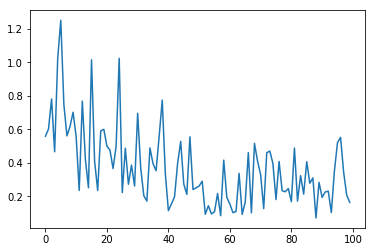

In [131]:
plt.plot(x)
plt.show()

In [160]:
coco.X_anchor

array([[ 6, 68],
       [25, 10],
       [33, 61],
       [60, 22],
       [38,  4],
       [ 4, 30],
       [14, 53],
       [20,  5],
       [70, 65],
       [31, 27],
       [13, 98],
       [31, 91],
       [39, 68],
       [60, 75],
       [80, 76],
       [26, 88],
       [65, 83],
       [ 0, 53],
       [92, 78],
       [69,  4]])

AttributeError: 'numpy.ndarray' object has no attribute 'append'